In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
def download_data(stock, start, end):
    data = yf.download(stock, start, end, auto_adjust=True)
    data.index = pd.to_datetime(data.index)
    return data

In [3]:
def generate_returns(stock):
    data['p_returns'] = data['Close'].pct_change()
    return data

In [4]:
def backtest_strategy(df, sma, mma, lma, print_chart):
    # Copy the data
    data = df.copy()
    
    # Create the moving averages
    data['sma'] = data['Close'].rolling(window=sma).mean()
    data['mma'] = data['Close'].rolling(window=mma).mean()
    data['lma'] = data['Close'].rolling(window=lma).mean()
    
    # Create the signal column
    data['signal'] = np.nan
    
    # Set the length of the dataframe
    n = data.shape[0]
    
    # Loop through each day to compute the signal
    for i in range(1, n): 
        
        # Set the first day signal to zero
        if i == 1:
            data['signal'].iloc[i-1] = 0.0
            
        # Check if the three moving averages have non-Nan values
        if data[['sma','mma','lma']].iloc[i].isnull().values.any():
            data['signal'].iloc[i] = 0.0
            continue
        
        # Set the conditions per each moving average
        cond_sma = data['Close'].iloc[i] >= data['sma'].iloc[i]
        cond_mma = data['Close'].iloc[i] >= data['mma'].iloc[i]
        cond_lma = data['Close'].iloc[i] >= data['lma'].iloc[i]

        # Check if we have no position in the asset
        if (data['signal'].iloc[i-1] == np.nan) | (data['signal'].iloc[i-1] == 0.0):
            # Check if we need to go long for today
            if cond_sma & cond_mma & cond_lma:
                data['signal'].iloc[i] = 1.0
            # Check if we need to go short for today
            elif (cond_sma==False) & (cond_mma==False) & (cond_lma==False):
                data['signal'].iloc[i] = -1.0
            else:
                data['signal'].iloc[i] = 0.0
        # Check if we are long for today
        elif data['signal'].iloc[i-1] == 1.0:
            # Check if we need to close our long position
            if (cond_sma==False) | (cond_mma==False) | (cond_lma==False):
                data['signal'].iloc[i] = 0.0
            # Carry the long position for the next day
            else:
                data['signal'].iloc[i] = 1.0
        # Check if we are short for today
        elif data['signal'].iloc[i-1] == -1.0:
            # Check if we need to close our short position
            if cond_sma | cond_mma | cond_lma:
                data['signal'].iloc[i] = 0.0
            # Carry the short position for the next day
            else:
                data['signal'].iloc[i] = -1.0

    # Print in case it's needed
    if print_chart == True:
        data[['signal', 'sma', 'mma', 'lma', 'Close']].iloc[50:130].plot(
            figsize=(10, 6), secondary_y='signal')

    # Compute the strategy returns
    data['strategy_returns'] = data['p_returns'] * data['signal'].shift(1)

    return data

In [5]:
def calculate_returns(data):
    bnh = (data['p_returns']+1).cumprod()[-1]
    s_returns = (data['strategy_returns']+1).cumprod()[-1]

    return bnh, s_returns

[*********************100%***********************]  1 of 1 completed
Buy and hold returns: 3.11
Strategy returns: 3.2


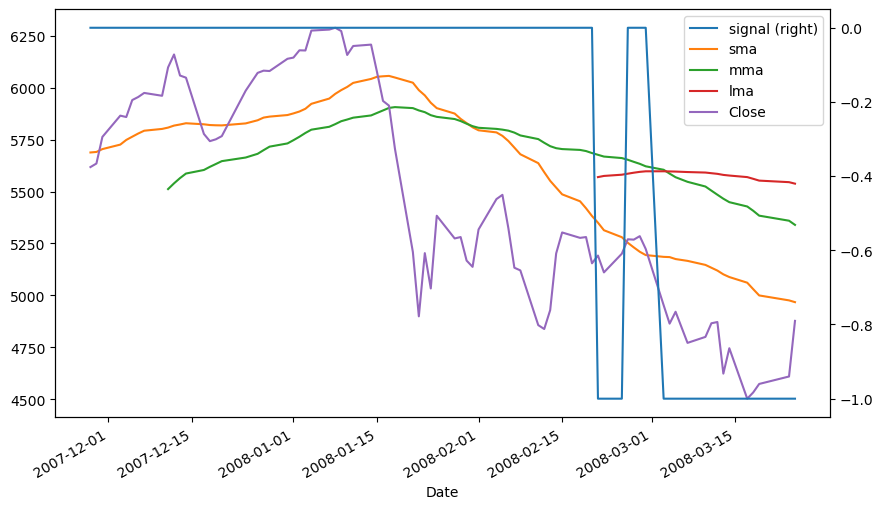

In [6]:
data = download_data('^NSEI', '2001-1-01', '2020-12-31')
data = generate_returns(data)
data = backtest_strategy(data, 30, 60, 110, True)

bnh, s_returns = calculate_returns(data)

print('Buy and hold returns:', np.round(bnh, 2))
print('Strategy returns:', np.round(s_returns, 2))

In [7]:
# Get the summary statistics for the strategy using pyfolio
import pyfolio as pf

pf.create_full_tear_sheet(data['strategy_returns'])

Start date,2007-09-17
End date,2020-12-30
Total months,154
,Backtest
Annual return,9.4%
Cumulative returns,220.3%
Annual volatility,19.2%
Sharpe ratio,0.57
Calmar ratio,0.36
Stability,0.73
Max drawdown,-26.0%


AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'